# **Overview** 
In this notebook we'll be creating a model to identify categories of brain tumors which could be giloma, meningioma, pituitary, or possibly no tumor. This model will involve a convolution build in terms of identifying these images. You can get the dataset from here:

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download


# **Unzip The File**
To access the dataset we need to unzip the file

In [2]:
!unzip '/content/brain_tumor_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# **Imports**
Imports we need for this project

In [3]:
import tensorflow as tf
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.data import AUTOTUNE
from sklearn.metrics import f1_score

# **Global Methods**
Methods used through this notebook 

In [14]:
def resetSeeds():
  seed_value = 1
  os.environ['PYTHONHASHSEED']=str(0)
  np.random.seed(seed_value)
  random.seed(seed_value)
  tf.random.set_seed(seed_value) 

def plotAccuracies(history, title):
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.yticks(np.arange(0.1, 1.1, .1))
  plt.grid()
  plt.show()  

def plotLosses(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.show() 

def getF1Score_And_Labels(testing_ds, model):
  true_labels = []
  predicted_labels = []

  for images, labels in testing_ds:
    true_labels.extend(labels)
    predicted_labels.extend(model.predict(images).argmax(axis=-1))
  f1score = f1_score(true_labels, predicted_labels, average='weighted')
  return true_labels, predicted_labels, f1score
  
def right_to_wrong(true_labels, predicted_labels):
  correct = 0
  wrong = 0
  data = []
  for true_label, predicted_value in zip(true_labels, predicted_labels):
    data.append({true_label.numpy().item() : predicted_value})

    if true_label == predicted_value:
      correct+=1
    else:
      wrong+=1
  sum = correct+wrong
  return correct/sum 

# **Data Prepping**
Here we setup our batch size, input shape with the given image size and channels, and apply that to our training and testing dataset. 

In [5]:
batch_size = 32
imgSize = (224, 224)
channels = 3
input_shape = (imgSize[0], imgSize[1], channels)
training_dir =  "/content/Training"
testing_dir =  "/content/Testing"
training_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.2,
    subset='training',
    seed = 1,
    image_size=(imgSize[0], imgSize[1]),
    batch_size = batch_size)

testing_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.2,
    subset='validation',
    seed = 1,
    image_size=(imgSize[0], imgSize[1]),
    batch_size = batch_size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [6]:
class_names = training_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
train_ds = training_ds.shuffle(1150).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_ds = testing_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# **Data Visualization**
Here we create a pie chart of what the percentage of images are of the following class names listed above. 

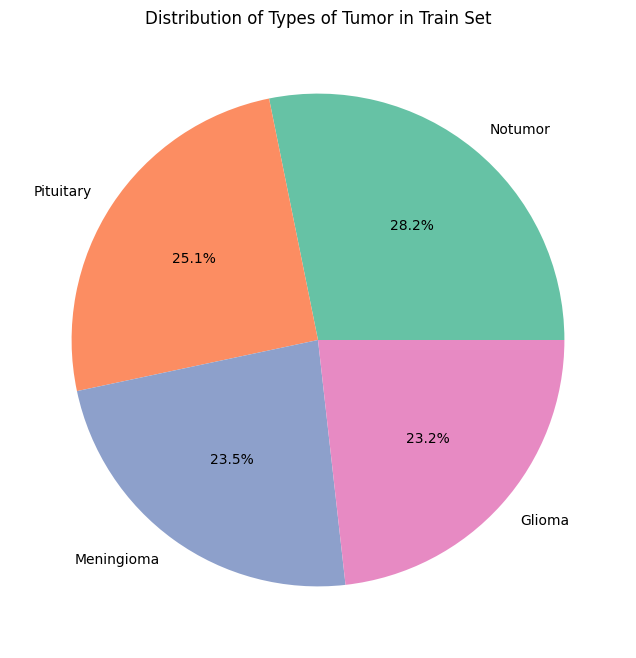

In [8]:
train_ds_labels = pd.Series([class_names[label.numpy()] for _, labels in training_ds for label in labels]).value_counts()
df = pd.DataFrame({'Category': train_ds_labels.index, 'Count': train_ds_labels.values})
df['Category'] = df['Category'].apply(lambda x : x.title())
plt.figure(figsize=(8, 8))
plt.pie(df['Count'], labels=df['Category'], autopct=lambda x: f'{x:.1f}%', colors=sns.color_palette("Set2"))
plt.title('Distribution of Types of Tumor in Train Set')
plt.show()

# **PeriodicNet** 
PeriodicNet is a convolution neural network architecture that follows a periodic sequence of given filters. 

In [9]:
classSize = len(class_names)

class PeriodicNetModel():

 def defineArchitecture(self):
        model = Sequential([
            Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(classSize, name='outputs'),
            Dropout(0.205)
        ])
        return model

 def compile(self, model):
        model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['sparse_categorical_accuracy'])

 def fit(self, model):
        #earlyStopping = tf.keras.callbacks.EarlyStopping(patience=5,  restore_best_weights=True, monitor='val_loss')
        return model.fit(training_ds, validation_data=testing_ds, epochs=100, verbose=1)


periodicnet_model = PeriodicNetModel()
resetSeeds()
periodicnet_model_architecture = periodicnet_model.defineArchitecture()
periodicnet_model.compile(periodicnet_model_architecture)
periodicnet_model_history = periodicnet_model.fit(periodicnet_model_architecture)


Epoch 1/100
143/143 [==============================] - 34s 99ms/step - loss: 1.1957 - sparse_categorical_accuracy: 0.5046 - val_loss: 0.8449 - val_sparse_categorical_accuracy: 0.6200
Epoch 2/100
143/143 [==============================] - 13s 88ms/step - loss: 0.7332 - sparse_categorical_accuracy: 0.6989 - val_loss: 0.6038 - val_sparse_categorical_accuracy: 0.7145
Epoch 3/100
143/143 [==============================] - 13s 90ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.4160 - val_sparse_categorical_accuracy: 0.8599
Epoch 4/100
143/143 [==============================] - 13s 89ms/step - loss: 0.4836 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.3047 - val_sparse_categorical_accuracy: 0.8888
Epoch 5/100
143/143 [==============================] - 13s 88ms/step - loss: 0.4415 - sparse_categorical_accuracy: 0.8243 - val_loss: 0.3208 - val_sparse_categorical_accuracy: 0.8818
Epoch 6/100
143/143 [==============================] - 13s 87ms/step - loss: 0.3665 -

# **PeriodicNet Metrics**
We graph/print the model's accuracy, loss, F1 Score, and Correct/Wrong Count

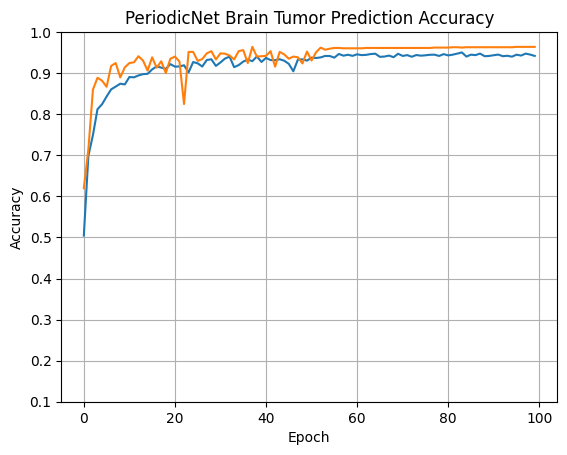

In [10]:
plotAccuracies(periodicnet_model_history, 'PeriodicNet Brain Tumor Prediction Accuracy')

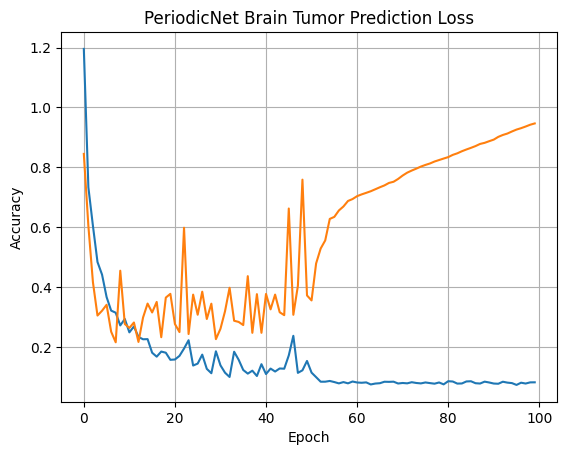

In [11]:
plotLosses(periodicnet_model_history, 'PeriodicNet Brain Tumor Prediction Loss')

In [12]:
trueLabels, predictionLabels, f1score = getF1Score_And_Labels(testing_ds, periodicnet_model_architecture)

1/1 [==============================] - 0s 135ms/step


In [17]:
print("Correct Prediction %:", right_to_wrong(trueLabels, predictionLabels) * 100)
print('F1 Score:', f1score)

Correct Prediction %: 96.40980735551665
F1 Score: 0.9640630992679643


# **Other**

In [19]:
periodicnet_model_architecture.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [18]:
periodicnet_model_architecture.save("brain_tumor_model.h5")